In [11]:
import random
import numpy as np
import copy
from tabulate import tabulate
from typing import List

def sphere(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2)

def weierstrass(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = len(x)
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result

def rosenbrock(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def schwefel(x, shift=None):
    if shift is not None:
        x = x - shift
    return abs(418.9829*len(x)-np.sum(x * np.sin(np.sqrt(np.abs(x)))))

def griewank(x, shift=None):
    if shift is not None:
        x = x - shift
    part1 = np.sum(x**2)/4000
    part2 = np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1))))
    return 1 + part1 - part2

def rastrigin(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2 - 10 * np.cos(2 * np.pi * x) + 10)

def ackley(x, shift=None):
    if shift is not None:
        x = x - shift
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x) / n)) + 20 + np.exp(1)

In [12]:
class SubPopulation:

    def __init__(self, fitness_function, shift_vector, low, high):
        self.fitness_function = fitness_function
        self.shift_vector = shift_vector
        self.limit = [low, high]
        self.generation = [[random.uniform(low, high) for x in range(50)] for y in range(100)]

    @property
    def covariance(self):
        cov_matrix = np.cov(np.array(copy.copy(self.generation)).T)
        reg_cov_matrix = cov_matrix + (1e-6) * np.identity(cov_matrix.shape[0])
        return reg_cov_matrix
        
    
    @property
    def mean(self):
        return np.mean(np.array(copy.copy(self.generation)), axis=0)
    
    def normal_distribution(self, x):
        tmp1 = (2*np.pi)**(np.pi/2)*np.linalg.det(self.covariance)
        tmp2 = -1/2*((x-self.mean).T@np.linalg.inv(self.covariance)@(x-self.mean))

        return (1/tmp1)*(np.exp(tmp2))

    def fitness(self, x):    
        return self.fitness_function(np.array(x), np.array(self.shift_vector))
    
    def crossover(self, x1, x2, eta_c= 2):
        rmp = random.uniform(0,1)
        son1 = copy.deepcopy(x1)
        son2 = copy.deepcopy(x2)

        u = random.uniform(0, 1)
        if random.random() < 0.5:
            beta = (2.0 * u)**(1.0 / (eta_c + 1.0))
        else:
            beta = (1.0 / (2.0 * (1.0 - u)))**(1.0 / (eta_c + 1.0))
        
        for k in range(len(x1)):
            son1[k] = 0.5*((1+beta)*x1[k]+(1-beta)*x2[k])
            if son1[k] > self.limit[1]:
                son1[k] = self.limit[1]
            if son1[k] < self.limit[0]:
                son1[k] = self.limit[0]

            son2[k] = 0.5*((1-beta)*x1[k]+(1+beta)*x2[k])
            if son2[k] > self.limit[1]:
                son2[k] = self.limit[1]
            if son2[k] < self.limit[0]:
                son2[k] = self.limit[0]
        return son1, son2
    
    def mutation(self, x, eta_m = 5):
        son = copy.deepcopy(x)
        for k in range(len(son)):
            if random.uniform(0,1)<0.02:
                u = random.uniform(0, 1)
                delta = 0
                if u <= 0.5:
                    delta = (2*u)**(1/(eta_m+1)) - 1
                    son[k] = son[k] + delta*(son[k]-self.limit[0])
                else:
                    delta = 1 - (2*(1-u))**(1/(eta_m+1))
                    son[k] = son[k] + delta*(self.limit[1]-son[k])
        return son
        
    def update_population(self, next_generation):
        self.generation += next_generation
        self.generation.sort(key = lambda x: self.fitness(x))
        self.generation = self.generation[0:100]

    def generate_offspring(self):
        offspring = []
        for k in range(50):
            rmp = random.uniform(0,1)
            if rmp > 0.3:
                parent1 = random.randint(0, len(self.generation)-1)
                parent2 = random.randint(0, len(self.generation)-1)

                son1, son2 = self.crossover(copy.deepcopy(self.generation[parent1]), copy.deepcopy(self.generation[parent2]))
                offspring.append(son1)
                offspring.append(son2)
            else:
                parent = random.randint(0, len(self.generation)-1)
                
                son = self.mutation(copy.deepcopy(self.generation[parent]))
                offspring.append(son)
       
        return offspring

In [13]:
class Framework:

    def __init__(self, fitness_functions, shift_vectors, lows, highs, alpha) -> None:
        self.multi_task : List[SubPopulation] = []
        for k in range(len(fitness_functions)):
            self.multi_task.append(SubPopulation(fitness_functions[k], shift_vectors[k], lows[k], highs[k]))
        self.epsilon : List[float] = [1 for x in range(len(self.multi_task))]
        self.alpha = alpha
        self.number_effective_individual = [0 for x in range(len(fitness_functions))]
    
    def select_individuals_for_transfer(self, target):
        individuals = []
        for task in range(len(self.multi_task)):
            if task == target:
                continue
            transfer_individual = copy.deepcopy(self.multi_task[task].generation)
            for x in range(len(transfer_individual)):
                for k in range (len(transfer_individual[x])):
                    transfer_individual[x][k]/=self.multi_task[task].limit[1]
                    transfer_individual[x][k]*=self.multi_task[target].limit[1]
            individuals+=transfer_individual
        
        if self.epsilon[target]==0:
            length = 50
        else:
            length = int(self.epsilon[target]*(len(self.multi_task)-1)*len(self.multi_task[target].generation))
        
        individuals.sort(key = lambda x: -self.multi_task[target].normal_distribution(np.array(x)))
        return individuals[0:length]

    def generate_next_generation(self):
        for k in range(len(self.multi_task)):
            offspring = self.multi_task[k].generate_offspring()
            self.multi_task[k].update_population(offspring)
            
            rmp = random.uniform(0,1)
            if rmp < self.alpha:
                if self.epsilon[k]>0.01:
                    print("Transfer:")
                    transfer_individual = self.select_individuals_for_transfer(k)
                    transfer_individual.sort(key = lambda x: self.multi_task[k].fitness(x))
                    old_generation = copy.deepcopy(self.multi_task[k].generation)

                    next_generation = []
                    number_of_individual = 0
                    number_of_individual_transfer = 0
                    number_of_individual_not_transfer = 0
                    max_pop = len(self.multi_task[k].generation)


                    while (number_of_individual<max_pop):
                        if number_of_individual_transfer < len(transfer_individual) and self.multi_task[k].fitness(old_generation[number_of_individual_not_transfer]) > self.multi_task[k].fitness(transfer_individual[number_of_individual_transfer]):
                            next_generation.append(transfer_individual[number_of_individual_transfer])
                            number_of_individual_transfer+=1
                        else:
                            next_generation.append(old_generation[number_of_individual_not_transfer])
                            number_of_individual_not_transfer+=1
                        number_of_individual+=1
                    
                    self.epsilon[k]=number_of_individual_transfer/len(transfer_individual)
                    self.number_effective_individual[k]+=number_of_individual_transfer

                    self.multi_task[k].generation=next_generation
        
                else:
                    self.epsilon[k]+=0.002
            

In [14]:
finess_functions = []
shift_vectors = []
lows = []
highs = []

#Sphere 1:
finess_functions.append(sphere)
shift_vectors.append([0 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 2:
finess_functions.append(sphere)
shift_vectors.append([80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Sphere 3:
finess_functions.append(sphere)
shift_vectors.append([-80 for x in range(50)])
lows.append(-100)
highs.append(100)

#Weierstrass 1:
finess_functions.append(weierstrass)
shift_vectors.append([-0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Rosenbrock:
finess_functions.append(rosenbrock)
shift_vectors.append([0 for x in range(50)])
lows.append(-50)
highs.append(50)

#Ackley:
finess_functions.append(ackley)
shift_vectors.append([40 for x in range(50)])
lows.append(-50)
highs.append(50)

#Weierstrass 2:
finess_functions.append(weierstrass)
shift_vectors.append([0.4 for x in range(50)])
lows.append(-0.5)
highs.append(0.5)

#Schwefel:
finess_functions.append(schwefel)
shift_vectors.append([420.9687 for x in range(50)])
lows.append(-500)
highs.append(500)

#Griewank:
finess_functions.append(griewank)
shift_vectors.append([-80 for x in range(25)]+[80 for x in range(25)])
lows.append(-100)
highs.append(100)

#Rastrign:
finess_functions.append(rastrigin)
shift_vectors.append([-40 for x in range(25)]+[40 for x in range(25)])
lows.append(-50)
highs.append(50)


In [15]:

model = Framework(finess_functions, shift_vectors, lows, highs, 0.1)
history = []
for x in range(1000):
    model.generate_next_generation()
    tmp = []
    for k in range(len(model.multi_task)):
        tmp.append(model.multi_task[k].fitness(model.multi_task[k].generation[0]))
    history.append(tmp)


Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:
Transfer:


KeyboardInterrupt: 

In [ ]:
headers = [f"T{i+1}" for i in range(len(history[0]))]
table = tabulate(history, headers=headers, tablefmt='grid')
print(table)

+-------------+------------+------------+---------+------------------+---------+---------+----------------+----------+-----------+
|          T1 |         T2 |         T3 |      T4 |               T5 |      T6 |      T7 |             T8 |       T9 |       T10 |
+=============+============+============+=========+==================+=========+=========+================+==========+===========+
| 87621.7     | 296875     | 330157     | 72.6408 |      1.55649e+09 | 20.8693 | 68.3272 | 6191.06        | 83.8619  | 66006.9   |
+-------------+------------+------------+---------+------------------+---------+---------+----------------+----------+-----------+
| 60457.9     | 296875     | 307874     | 72.6408 |      1.55649e+09 | 20.8693 | 63.3273 | 6191.06        | 83.8619  | 57939.2   |
+-------------+------------+------------+---------+------------------+---------+---------+----------------+----------+-----------+
| 50227.9     | 270936     | 307874     | 72.6408 |      9.31054e+08 | 20.8693 | 63

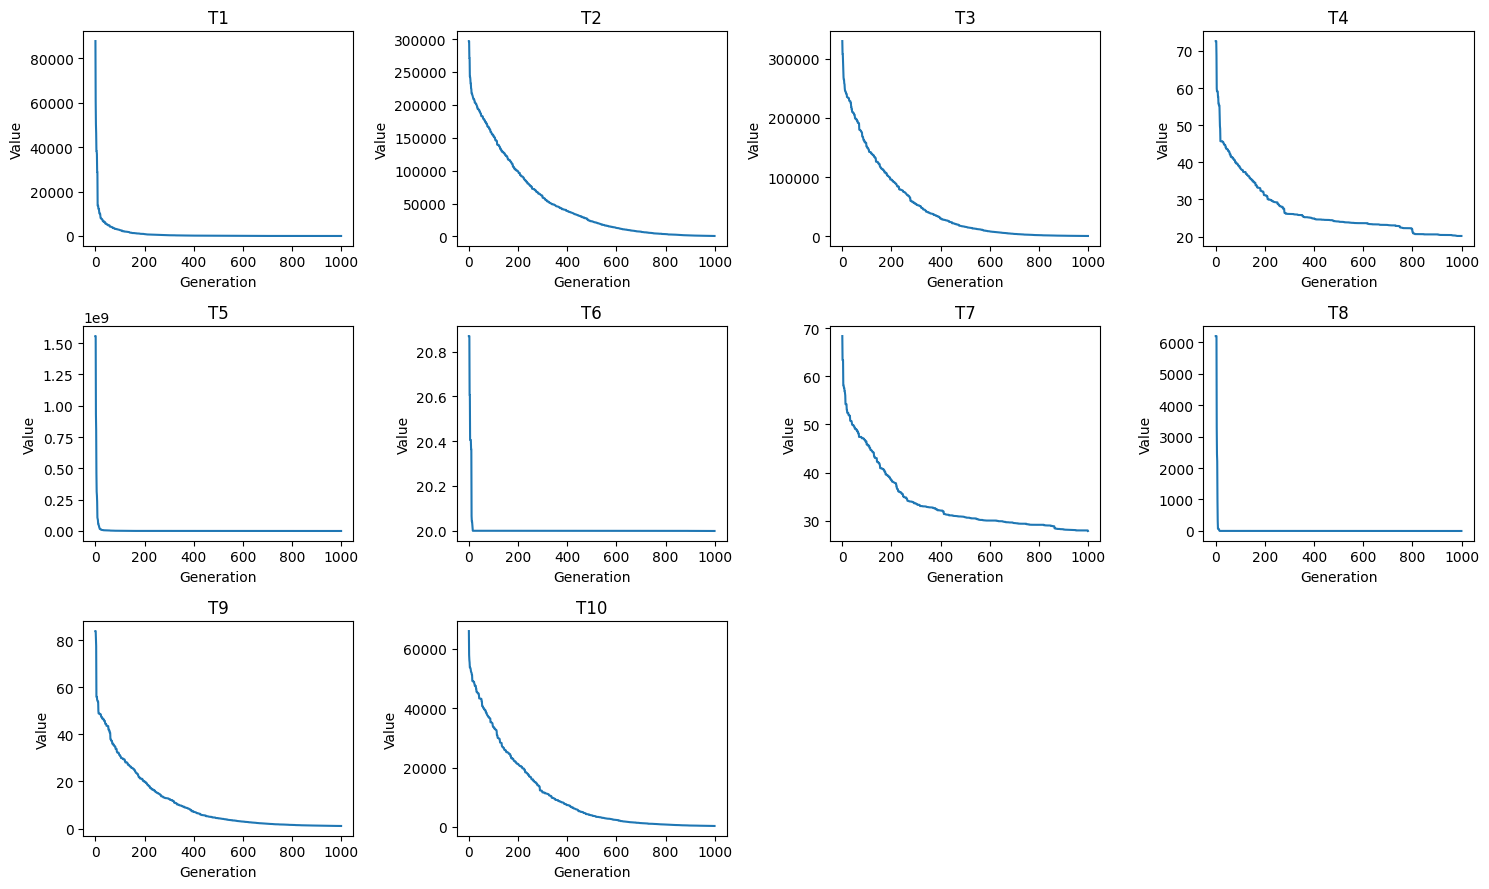

In [ ]:
import matplotlib.pyplot as plt

def plot_functions(history):
    num_functions = len(history[0])  # Số lượng hàm
    num_points = len(history)  # Số lượng điểm
    num_plots_per_row = 4  # Số lượng đồ thị trên mỗi hàng

    num_rows = (num_functions + num_plots_per_row - 1) // num_plots_per_row

    # Tạo subplot với kích thước phù hợp
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows*3))

    for j in range(num_functions):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].plot(range(num_points), history[:, j])
        axs[row_index, col_index].set_title(f'T{j+1}')
        axs[row_index, col_index].set_xlabel('Generation')
        axs[row_index, col_index].set_ylabel('Value')

    # Nếu số lượng hàm không phải là bội số của num_plots_per_row, ẩn các subplot không cần thiết
    for j in range(num_functions, num_rows*num_plots_per_row):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()


plot_functions(np.array(history))


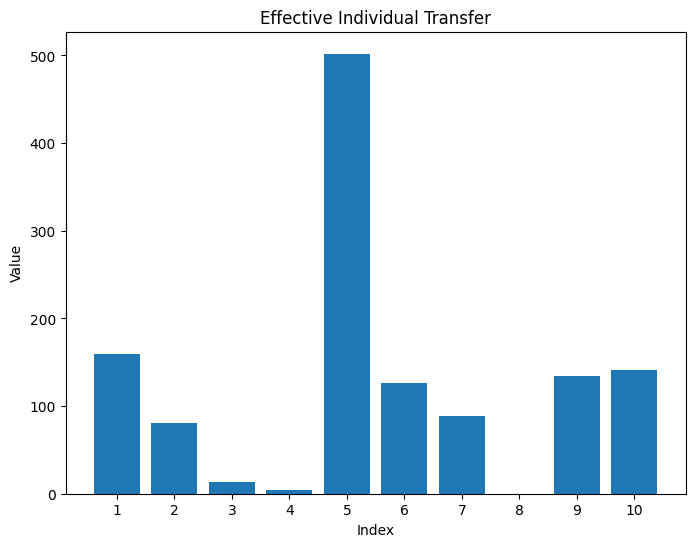

[159, 81, 13, 4, 502, 126, 89, 0, 134, 141]


In [ ]:
import matplotlib.pyplot as plt

def plot_bar_chart(data):
    # Tạo biểu đồ cột từ dữ liệu
    plt.figure(figsize=(8, 6))  # Đặt kích thước của biểu đồ
    plt.bar(range(len(data)), data)
    plt.xticks(range(len(data)), range(1, len(data) + 1)) 
    # Đặt nhãn cho trục x và trục y
    plt.xlabel('Index')
    plt.ylabel('Value')
    
    # Đặt tiêu đề cho biểu đồ
    plt.title('Effective Individual Transfer')
    
    # Hiển thị biểu đồ
    plt.show()

plot_bar_chart(model.number_effective_individual)
print(model.number_effective_individual)